In [2]:
import geogridstore
import numpy as np
import geopandas as gpd
import geodatasets as gds
import matplotlib.pyplot as plt
from shapely.geometry import Point
import random

import pvdeg

Download dataset, read into geopandas dataframe and plot the polygons.

<Axes: >

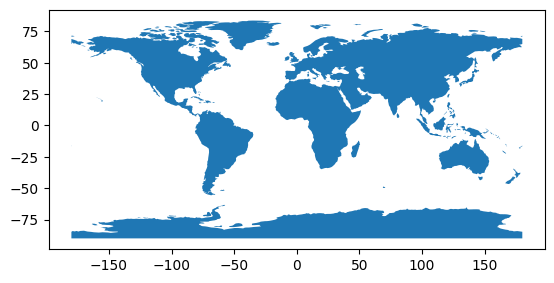

In [3]:
fp = gds.get_path("naturalearth.land")

world = gpd.read_file(fp)
world.plot()

<Axes: >

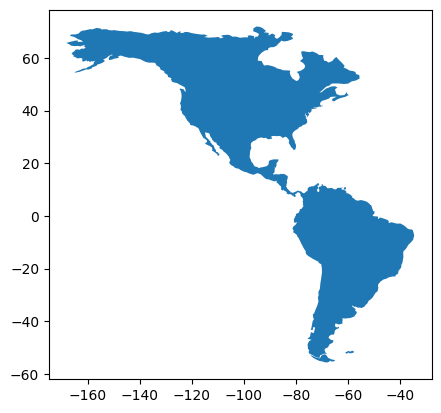

In [4]:
# Define bounding boxes for NA and SA
americas_box = world.cx[-82:-35, -56:15] # Longitude, Latitude

americas_box.plot()

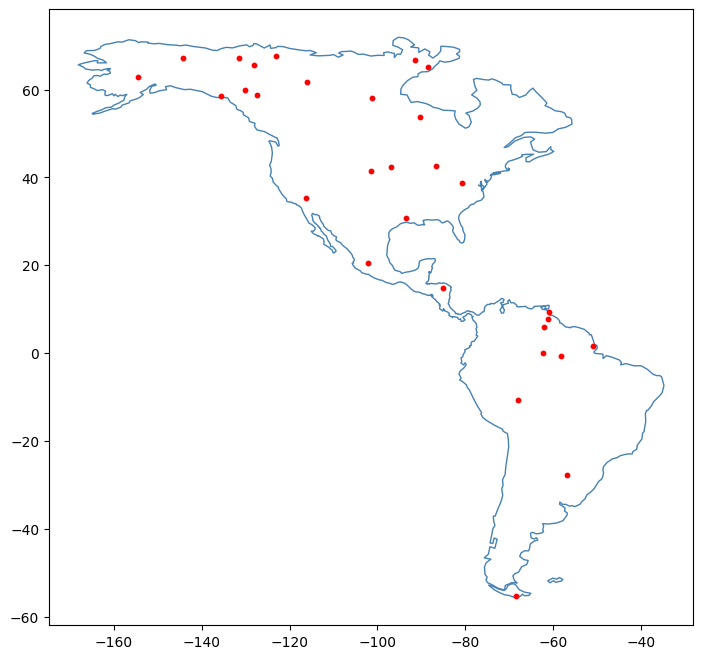

In [9]:
pointcount = 30

aoi_geom = americas_box.union_all()

xmin, ymin, xmax, ymax = aoi_geom.bounds
xext = xmax - xmin
yext = ymax - ymin

# Generate random points within the bounds of americas_box
points = []
while len(points) < pointcount:
    # Generate random x, y coordinates
    x = xmin + random.random() * xext
    y = ymin + random.random() * yext
    p = Point(x, y)
    if aoi_geom.contains(p):  # Check if the point is inside the geometry
        points.append(p)

# Create a GeoSeries for the points
gs = gpd.GeoSeries(points)

fig, ax = plt.subplots(figsize=(10, 8))
americas_box.plot(ax=ax, facecolor='none', edgecolor='steelblue')
gs.plot(ax=ax, color='red', markersize=10)
plt.show()

In [6]:
client = pvdeg.geospatial.start_dask()

Dashboard: http://127.0.0.1:8787/status


In [10]:
coords = np.column_stack((gs.y, gs.x)) # (lat, long)
tuple_coords = [tuple(coord) for coord in coords] # we need to pass a list of tuples not a numpy array

weather, meta, failed = pvdeg.weather.weather_distributed(
    database="PVGIS",
    coords=tuple_coords,
)

Connected to a Dask scheduler | Dashboard: http://127.0.0.1:8787/status


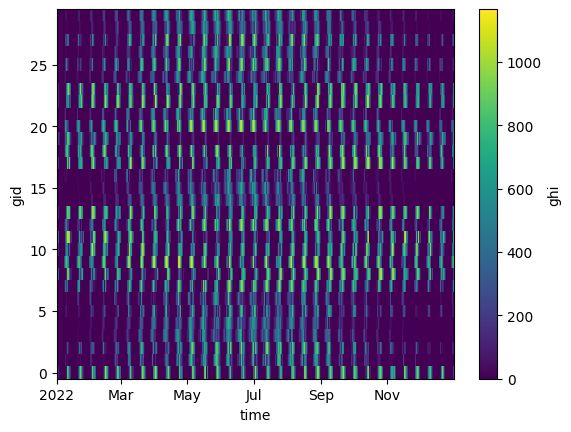

In [11]:
weather.ghi.plot()

In [12]:
weather

<xarray.Dataset> Size: 19MB
Dimensions:            (gid: 30, time: 8760)
Coordinates:
  * time               (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T2...
  * gid                (gid) int32 120B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
Data variables:
    temp_air           (gid, time) float64 2MB dask.array<chunksize=(30, 8760), meta=np.ndarray>
    relative_humidity  (gid, time) float64 2MB dask.array<chunksize=(30, 8760), meta=np.ndarray>
    ghi                (gid, time) float64 2MB dask.array<chunksize=(30, 8760), meta=np.ndarray>
    dni                (gid, time) float64 2MB dask.array<chunksize=(30, 8760), meta=np.ndarray>
    dhi                (gid, time) float64 2MB dask.array<chunksize=(30, 8760), meta=np.ndarray>
    IR(h)              (gid, time) float64 2MB dask.array<chunksize=(30, 8760), meta=np.ndarray>
    wind_speed         (gid, time) float64 2MB dask.array<chunksize=(30, 8760), meta=np.ndarray>
    wind_direction     (gid, time) float64 2MB dask.array<chunksize=(30, 8760), meta=np.ndarray>
    pressure           (gid, time) float64 2MB dask.array<chunksize=(30, 8760), meta=np.ndarray>

### Saving Points

When we save points we want to add them to the rtree, then save them

In [14]:
info_struct = geogridstore.core.point_info(
    source="PVGIS",
    tmy=True,
    periods=8760
)

geogridstore.index._index_add_points(
    gid=np.arange(len(coords)), # gids are arbitrary, not required to be unique for rdtree
    arr=coords,
    point_info=info_struct
)

In [15]:
# test cell, we can see how thi
import rtree
from geogridstore import INDEX_PATH

properties = rtree.index.Property()
properties.dimension = 2

file_idx = rtree.index.Index(INDEX_PATH.__str__(), properties=properties)
file_idx

rtree.index.Index(bounds=[-55.216628620326524, -161.86403348951634, 70.39250309503734, -50.864436481518354], size=60)

In [17]:
target_coord = coords[0]

query = (target_coord[0], target_coord[1], target_coord[0], target_coord[1])

In [18]:
# does this give us any information about the points these were stored at
# we want to see a mapping from coordiante -> data
y = list(file_idx.nearest(query, num_results=2, objects=True))

In [19]:
coords[0]

array([  7.75137646, -61.06017914])

In [20]:
for item in y:
    coord = item.bbox[:2]
    print(item.id)
    print(coord)
    print(item.object)

0
[7.751376461473932, -61.06017913985795]
PVGIS,True,8760
22
[9.342858128133606, -60.914053748336855]
PVGIS,True,8760


In [26]:
for element in list(file_idx.intersection(file_idx.bounds, objects=True)):
    coord = element.bbox[:2]
    print(element.id)
    print(coord)
    print(item.object)

0
[48.84131016983367, -86.63581393573935]
PVGIS,True,8760
1
[33.282578710248224, -109.97867074894545]
PVGIS,True,8760
2
[29.970217406784123, -111.0097285212123]
PVGIS,True,8760
3
[62.056454686651584, -111.50085561346626]
PVGIS,True,8760
4
[59.23080049559508, -136.7268916631448]
PVGIS,True,8760
5
[68.34658519750403, -161.86403348951634]
PVGIS,True,8760
6
[34.68186453736518, -80.07530132777329]
PVGIS,True,8760
7
[68.72288453452182, -119.6383852110248]
PVGIS,True,8760
8
[-14.216850414738381, -75.55456137739782]
PVGIS,True,8760
9
[-39.54918577970684, -64.17938457532132]
PVGIS,True,8760
10
[49.643062337561624, -119.00991437631852]
PVGIS,True,8760
11
[62.28653988161388, -149.50745066781482]
PVGIS,True,8760
12
[67.40620600045929, -149.01270210336617]
PVGIS,True,8760
13
[53.38736825632443, -73.51477668678129]
PVGIS,True,8760
14
[3.631951527049658, -71.37475630217516]
PVGIS,True,8760
15
[68.33820987292566, -142.713128144001]
PVGIS,True,8760
16
[53.27055840898115, -102.89144712098705]
PVGIS,True